In [1]:
# This is an example of the comparison of images using the HOG technique
#
# Prepared by Juan D. Soler (soler@mpia.de)

import sys
sys.path.append('../pyastrohog/')
from astrohog2d import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits

from scipy import ndimage

In [2]:
# Load two test images
image1 = scipy.ndimage.imread('../data/image.001.png', flatten=True)
image2 = scipy.ndimage.imread('../data/image.002.png', flatten=True)
ksz=3.

In [3]:
# Calculate the relative orientation angles using the tools in the astroHOG package
circstats, corrframe, smoothframe1, smoothframe2 = HOGcorr_frame(image1, image2, ksz=ksz)

In [4]:
# Print the correlation statistics
print('Mean resultant vector (r)        ', circstats[0])
print('Rayleigh statistic (Z)           ', circstats[1])
print('Projected Rayleigh statistic (V) ', circstats[2])
print('Rayleigh statistic (ii)          ', circstats[5], '+/-', circstats[6])
print('Mean angle                       ', circstats[7])
print('Alignment measure (AM)           ', circstats[8])

Mean resultant vector (r)         0.115822
Rayleigh statistic (Z)            1172.19668135
Projected Rayleigh statistic (V)  10050.1382026
Rayleigh statistic (ii)           144.244394505 +/- 0.946279560747
Mean angle                        0.0590659373304
Alignment measure (AM)            0.357251


In [5]:
dI1dx=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[0,1], mode='nearest')
dI1dy=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[1,0], mode='nearest')
normgrad1=np.sqrt(dI1dx**2+dI1dy**2)
udI1dx=dI1dx/normgrad1
udI1dy=dI1dy/normgrad1

In [6]:
dI2dx=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[0,1], mode='nearest')
dI2dy=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[1,0], mode='nearest')
normgrad2=np.sqrt(dI2dx**2+dI2dy**2)
udI2dx=dI2dx/normgrad1
udI2dy=dI2dy/normgrad1

In [24]:
pitch=40
sz=np.shape(image1)
X, Y = np.meshgrid(np.arange(0, sz[1]-1, pitch), np.arange(0, sz[0]-1, pitch))
ux1=dI1dx[Y,X]
uy1=dI1dy[Y,X]
ux2=dI2dx[Y,X]
uy2=dI2dy[Y,X]

In [25]:
# Computing the histogram of relative orientations
hist, bin_edges = np.histogram(corrframe*180.0/np.pi, density=True, range=[-90.,90.], bins=40)
bin_center=0.5*(bin_edges[0:np.size(bin_edges)-1]+bin_edges[1:np.size(bin_edges)])

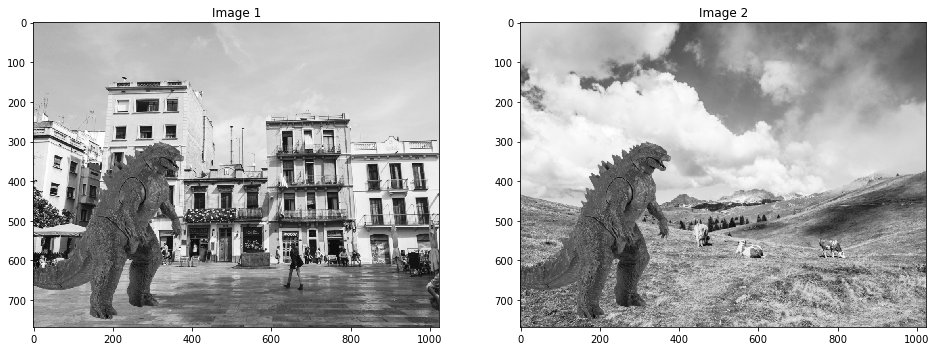

In [26]:
fig, ax = plt.subplots(1,2, figsize=(16., 12.))
ax[0].imshow(image1, cmap='Greys_r')
ax[0].set_title('Image 1')
ax[1].imshow(image2, cmap='Greys_r')
ax[1].set_title('Image 2')
plt.show()

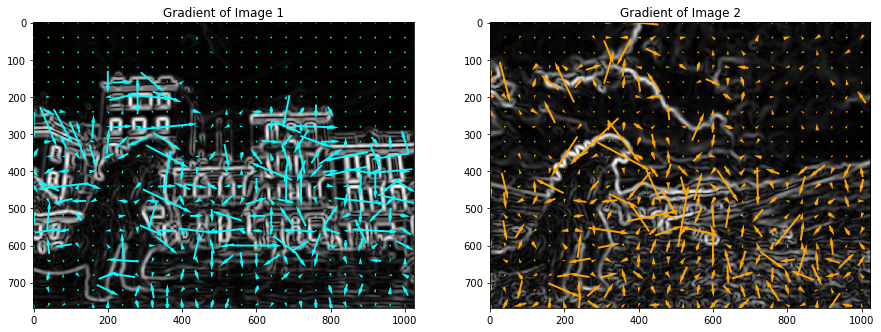

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15., 10.))
ax[0].imshow(normgrad1, cmap='Greys_r')
arrows=ax[0].quiver(X, Y, ux1, uy1, units='width', color='cyan', pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[0].set_title('Gradient of Image 1')
ax[1].imshow(normgrad2, cmap='Greys_r')
arrows=ax[1].quiver(X, Y, ux2, uy2, units='width', color='orange',  pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[1].set_title('Gradient of Image 2')
plt.show()

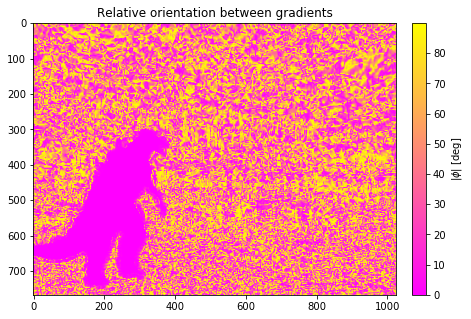

In [28]:
fig, ax = plt.subplots(1,1, figsize=(7.5, 5.))
im=plt.imshow(np.abs(corrframe)*180.0/np.pi, cmap='spring')
cb1=plt.colorbar(im,fraction=0.046, pad=0.04)
cb1.set_label(r'$|\phi|$ [deg]')
ax.set_title('Relative orientation between gradients')
plt.show()

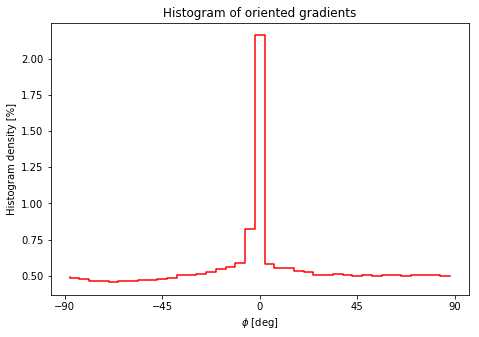

In [29]:
# Show the histogram of oriented gradients
fig, ax = plt.subplots(1,1, figsize=(7.5, 5.))
ax.step(bin_center, hist*100, color='red')
ax.set_ylabel('Histogram density [%]')
ax.set_xlabel(r'$\phi$ [deg]')
ax.set_xticks([-90.,-45.,0.,45.,90.])
ax.set_title('Histogram of oriented gradients')
plt.show()